In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("seaborn")

import warnings
warnings.filterwarnings("ignore")

E:\Studium\HPI\22 SS\Deep Learning\Projekt\histopathology-cancer-detection\new_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create Dataset

In [2]:
class HistopathologicImageDataset(Dataset):
    def __init__(self, labels_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(labels_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(f"{img_path}.tif")
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## Create Dataloader

In [3]:
def get_train_and_test_loader():
    '''load dataset and return dataloader for training and testing '''
    dataset = HistopathologicImageDataset(labels_file="./data/train_labels.csv", img_dir="./data/train/", transform=transforms.Compose([
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(dtype=torch.float32),
        transforms.Normalize([0.7025, 0.5463, 0.6965], [0.2389, 0.2821, 0.2163]),
    ]))

    train_set, test_set = random_split(dataset, [176_020, 44_005])
    train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
    test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=False)

    return train_loader, test_loader

In [4]:
_, test_loader = get_train_and_test_loader()

## Create model

In [5]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        modules = []

        # input_shape=[3,96,96], output_shape=[16,94,94]
        modules.append(nn.Conv2d(in_channels=img_dim[0], out_channels=16, kernel_size=3))
        modules.append(nn.ReLU())
        # input_shape=[16,94,94], output_shape=[32,92,92]
        modules.append(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3))
        modules.append(nn.ReLU())
        modules.append(nn.Dropout2d(0.2))

        # input_shape=[32,92,92], output_shape=[32,46,46]
        modules.append(nn.MaxPool2d(kernel_size=2, stride=2))
        modules.append(nn.BatchNorm2d(32))
        
        # input_shape=[32,46,46], output_shape=[64,44,44]
        modules.append(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3))
        modules.append(nn.ReLU())
        # input_shape=[64,44,44], output_shape=[128,42,42]
        modules.append(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3))
        modules.append(nn.ReLU())
        
        # input_shape=[128,42,42], output_shape=[128,21,21]
        modules.append(nn.MaxPool2d(kernel_size=2, stride=2))
        modules.append(nn.Dropout2d(0.2))
        # GlobalAveragePooling
        # input_shape=[128,21,21], output_shape=[128,1,1]
        modules.append(nn.AdaptiveAvgPool2d(1))
        modules.append(nn.BatchNorm2d(128))
        
        # input_shape=[128,1,1], output_shape=[128]
        modules.append(nn.Flatten())
        modules.append(nn.Linear(in_features=128, out_features=64))
        modules.append(nn.ReLU())
        modules.append(nn.Linear(in_features=64, out_features=32))
        modules.append(nn.ReLU())
        modules.append(nn.Dropout(0.2))
        modules.append(nn.Linear(in_features=32, out_features=16))
        modules.append(nn.ReLU())
        modules.append(nn.Linear(in_features=16, out_features=1))
        modules.append(nn.Sigmoid())

        self.model = nn.Sequential(*modules)
    
    def forward(self, imgs):
        return self.model(imgs).flatten()

## Train model

In [6]:
'''
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

for epoch in tqdm(range(epochs)):

    for idx, data in tqdm(enumerate(train_loader, 0)):
        imgs, labels = data[0].to(device), data[1].to(torch.float32).to(device)

        optimizer.zero_grad()

        preds = net(imgs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
''';

## Plot training metrics

In [7]:
path = "./trained_models/cnn2_train.csv"
training_metrics = pd.read_csv(path)
training_metrics = training_metrics.drop(["Unnamed: 0"], axis=1)

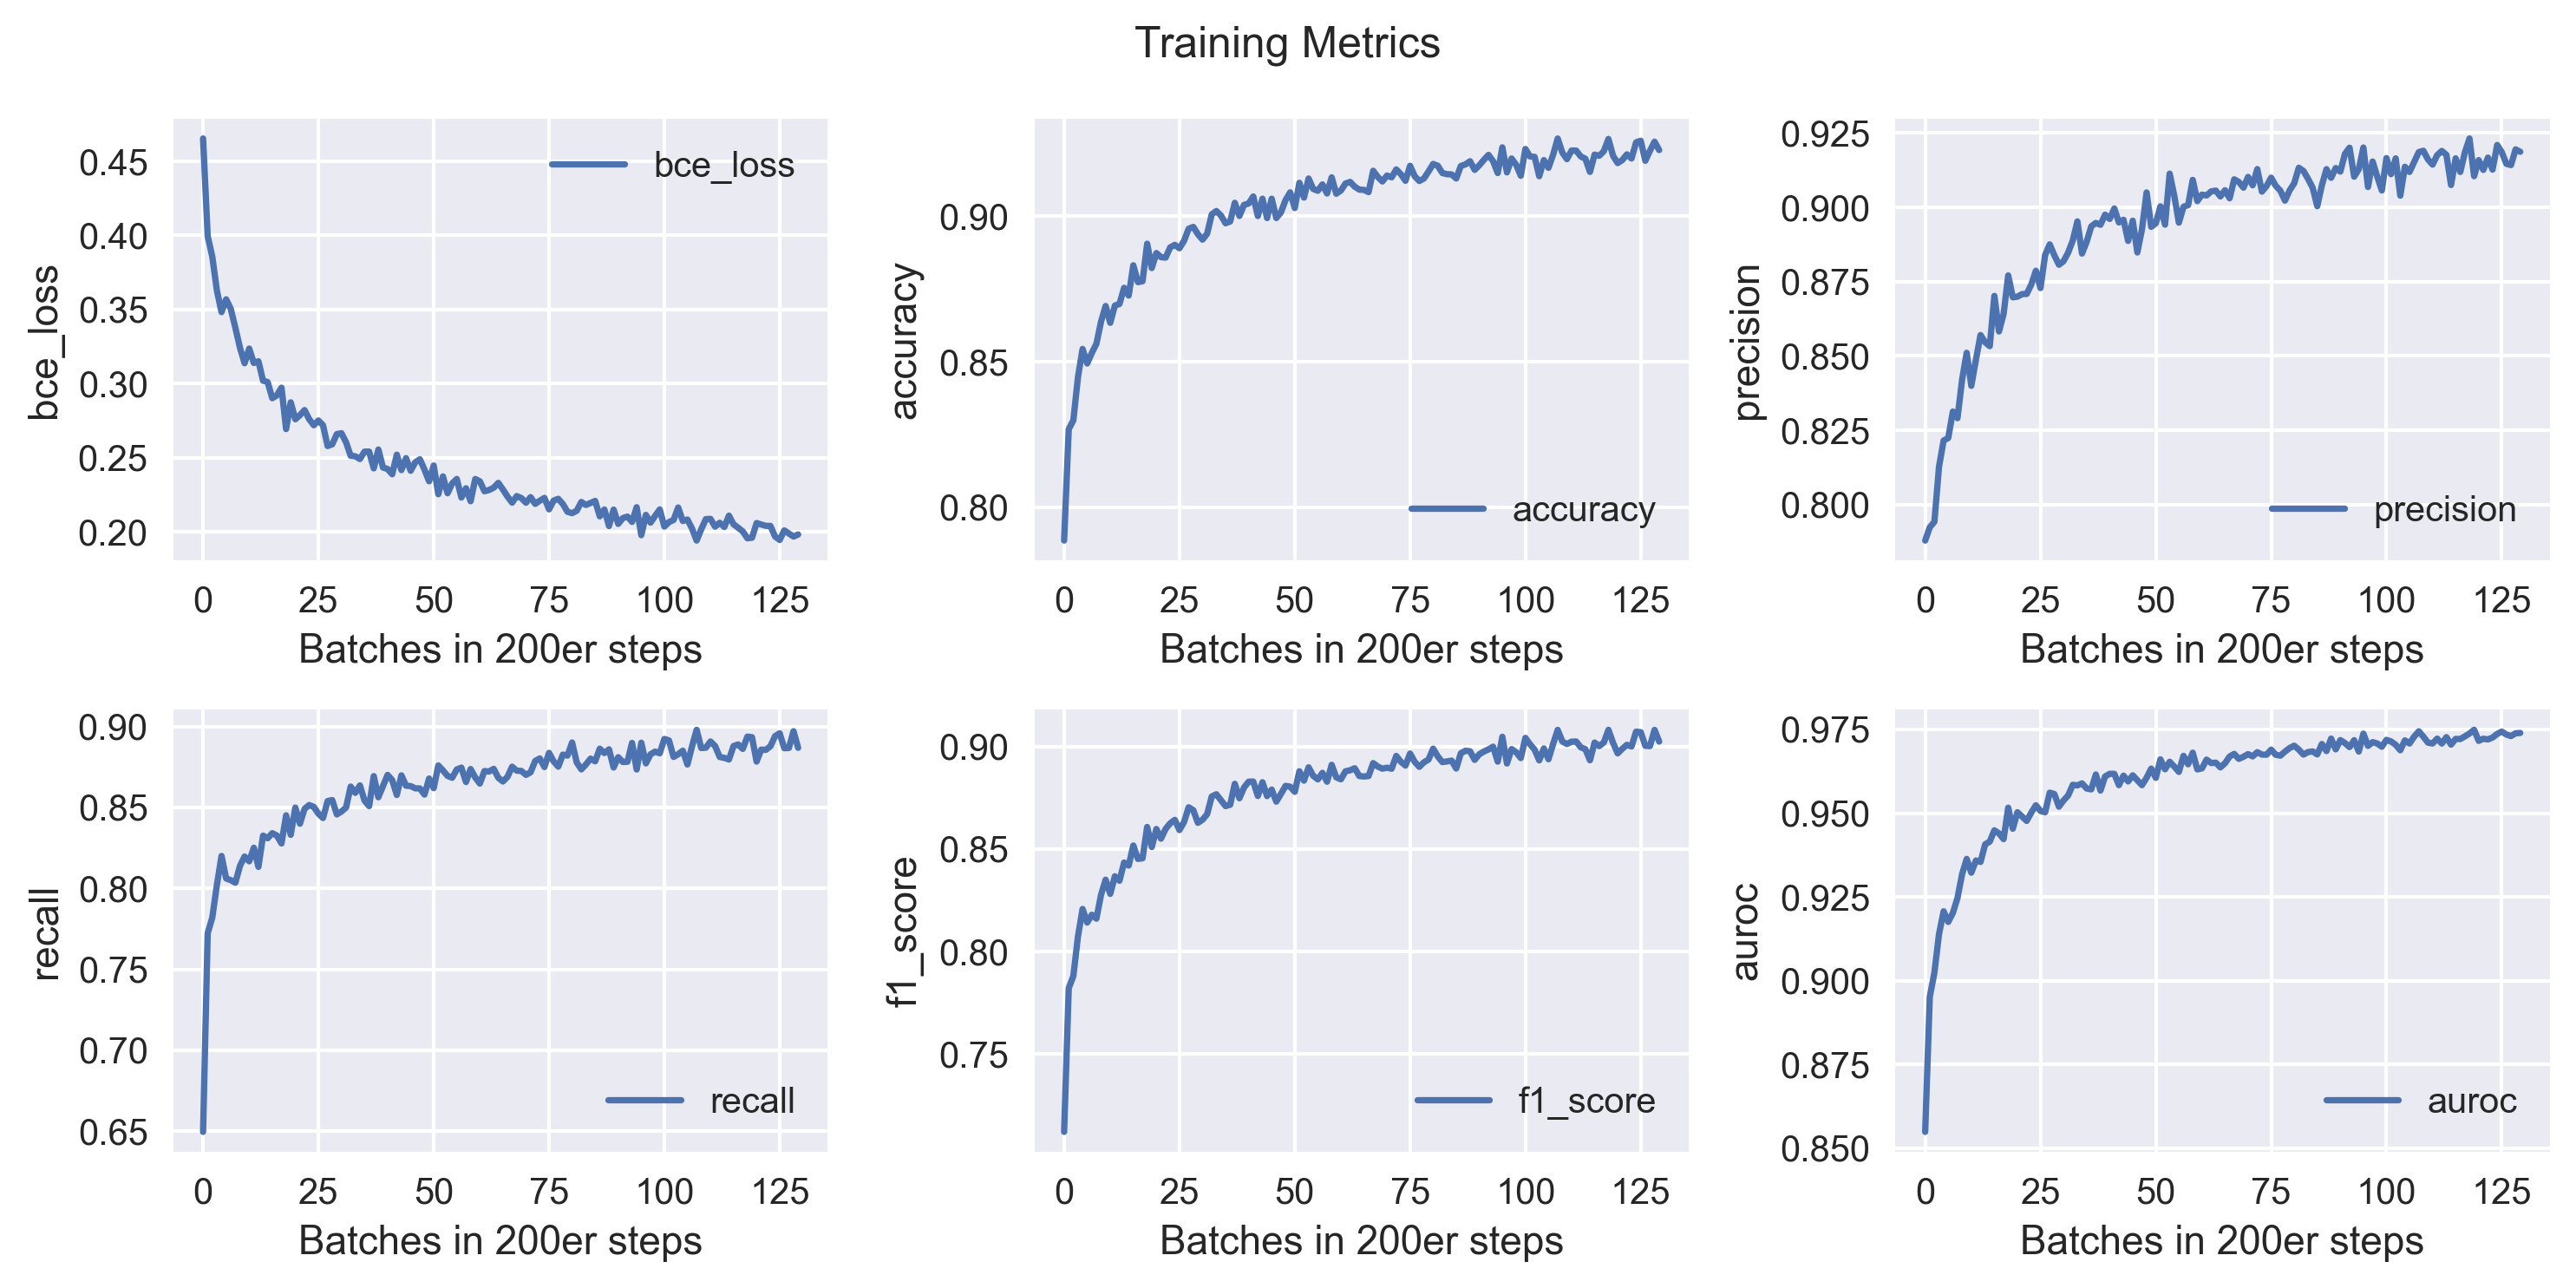

In [8]:
fig = plt.figure(dpi=300, figsize=(10,5))
for idx, col_name in enumerate(training_metrics.columns):
    fig.suptitle("Training Metrics")
    ax = fig.add_subplot(2,3,idx+1)
    ax.plot(training_metrics.index.values, training_metrics[col_name], label=col_name)
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='Batches in 200er steps', ylabel=col_name)
fig.tight_layout()

## Evaluate model

In [9]:
'''
# Create testing metrics
metric_collection = MetricCollection([
    Accuracy(),
    Precision(),
    Recall(),
    F1Score(),
    AUROC()
])

list_of_labels = []
list_of_preds = []


with torch.no_grad():
    for data in tqdm(test_loader):
        imgs, labels = data
        preds = net(imgs)
        list_of_preds.append(preds)
        list_of_labels.append(labels)


labels = torch.cat(list_of_labels)
preds = torch.cat(list_of_preds)

# Calculate metrics
metrics = metric_collection(preds, labels)
''';

## Plot test metrics

In [10]:
path = "./trained_models/cnn2_test.csv"
test_metrics = pd.read_csv(path)
test_metrics = test_metrics.drop(["Unnamed: 0"], axis=1)

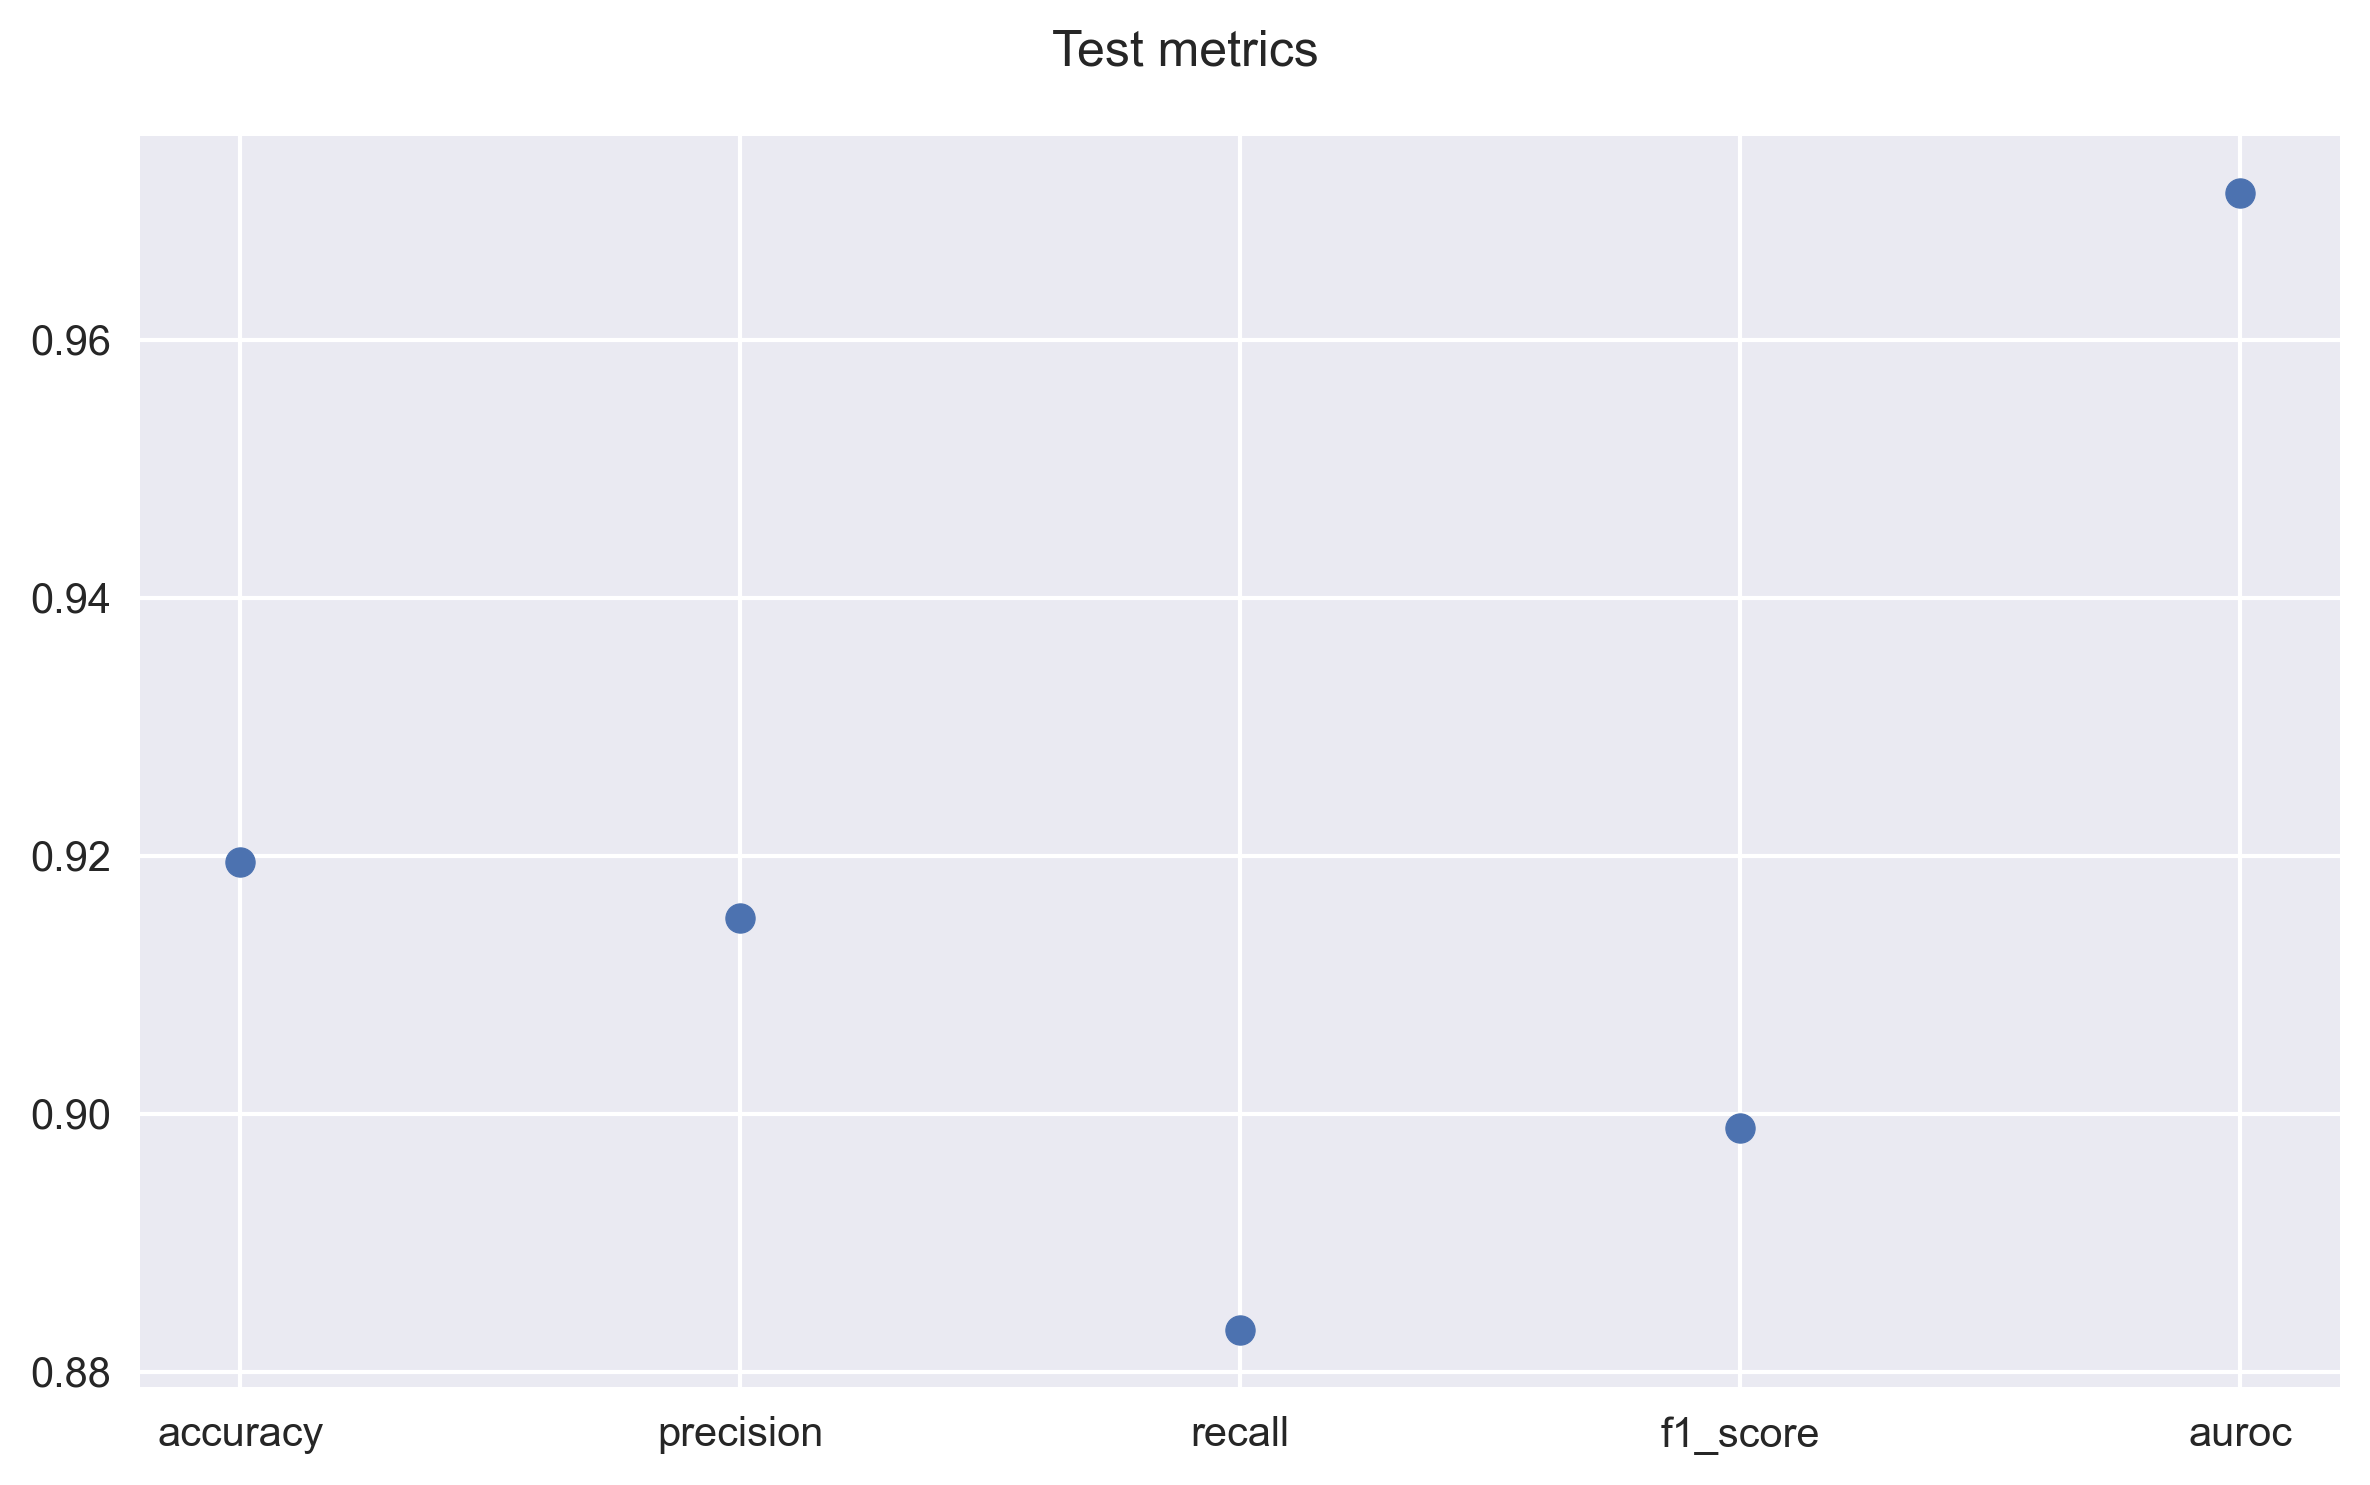

In [11]:
fig = plt.figure(figsize=(10,5), dpi=300)
fig.set_size_inches(8, 5)
ax = fig.add_subplot(1,1,1)
fig.suptitle(f'Test metrics')
data = test_metrics.iloc[0]
ax.grid(True)
ax.scatter(test_metrics.columns, data)
fig.tight_layout()

## Plot confusion matrix?

## Randomly sample 20 images from test set

In [12]:
sample_batch = next(iter(test_loader))
imgs = sample_batch[0][:20]
labels = sample_batch[1][:20]

## Denormalize images for visualization

In [13]:
mean = torch.tensor([0.7025, 0.5463, 0.6965], dtype=torch.float32)
std = torch.tensor([0.2389, 0.2821, 0.2163], dtype=torch.float32)

# https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/20
inverse_normalization = transforms.Normalize((-mean/std).tolist(), (1.0/std).tolist())
imgs_display = inverse_normalization(imgs)

# Change channel order for matplotlib
imgs_display = (imgs_display.permute(0,2,3,1).numpy() * 255).astype(np.uint8)

## Load Model

In [14]:
from architecture.cnn_2 import Net

path = "./trained_models/cnn2.pth"
net = Net(img_dim=[3, 96, 96])
net.load_state_dict(torch.load(path))
net.cpu()

Net(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Dropout2d(p=0.2, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.2, inplace=False)
    (13): AdaptiveAvgPool2d(output_size=1)
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=128, out_features=64, bias=True)
    (17): ReLU()
    (18): Linear(in_features=64, out_features=32, bias=True)
    (19): ReL

In [15]:
preds = net(imgs)
preds = torch.gt(preds, 0.5).to(torch.uint8)

## Compare Prediction with Ground Truth

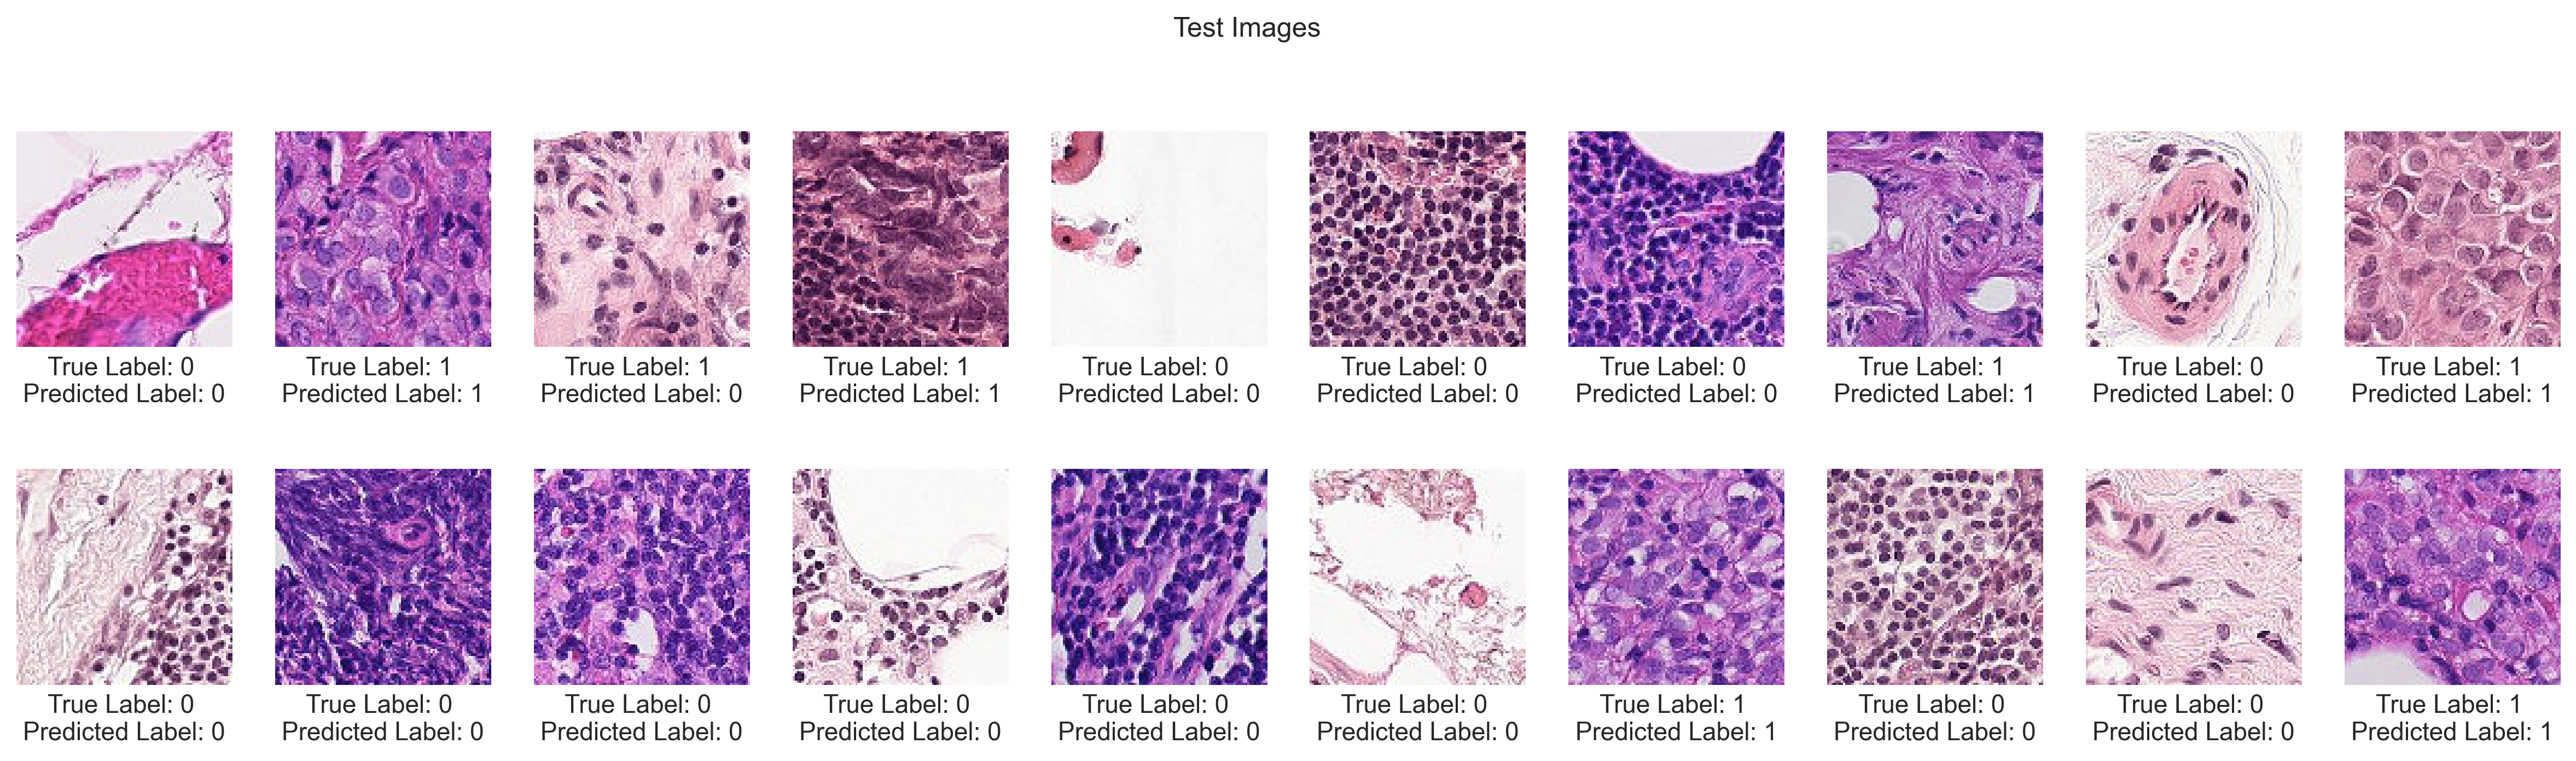

In [16]:
fig = plt.figure(figsize=(20, 5), dpi=300)
fig.suptitle("Test Images")
for i in range(1, 20 + 1):
    img = imgs_display[i-1]
    fig.add_subplot(2, 10, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"True Label: {labels[i-1].item()} \nPredicted Label: {preds[i-1].item()}")
plt.show()